<a href="https://colab.research.google.com/github/JonathanCecil01/OfficePlacementM7/blob/main/RFIS_TimeRange_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import math
import csv
from copy import deepcopy
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras import layers

2023-05-16 09:41:16.222704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Reading data for training 

In [3]:
def read_data():
    landmarks = []
    with open('Active_Landmarks.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            landmarks.append(row)
    file.close()
    for landmark in landmarks:
        landmark[1] = float(landmark[1])
        landmark[2] = float(landmark[2])
    start = landmarks[0][2]
    products = []


    with open('Products.csv', 'r') as file1:
        reader = csv.reader(file1)
        for row in reader:
            products.append(row) 
    for product in products:
        product[2] = float(product[2])
        product[3] = float(product[3])
        product[2] = float("{:.0f}".format(product[2]))
        product[3] = float("{:.0f}".format(product[3]))
    
    return [products, landmarks]

Organising Data into a Dictionary


In [4]:
data = read_data()
products = data[0]
landmarks = data[1]

Getting Top ten Timestamps

In [5]:
unique_list = list(set(tuple(inner_list) for inner_list in landmarks))

unique_list_of_lists = [list(inner_tuple) for inner_tuple in unique_list]

landmarks = unique_list_of_lists

In [6]:
unique_list = list(set(tuple(inner_list) for inner_list in products))

unique_list_of_lists = [list(inner_tuple) for inner_tuple in unique_list]

products = unique_list_of_lists

In [7]:
product_dict = {}
for i in products:
  product_dict[i[0]] = []
for i in products:
  product_dict[i[0]].append(i)

for key in product_dict.keys():
  product_dict[key].sort(key=lambda x: -x[2])

for key in product_dict.keys():
  product_dict[key] = product_dict[key][:int(len(product_dict[key])/10)]
print(product_dict)

{'527': [['527', 'P30', -74.0, 17145.0, 'L4'], ['527', 'P30', -74.0, 17090.0, 'L4'], ['527', 'P30', -74.0, 17057.0, 'L4'], ['527', 'P30', -74.0, 19397.0, 'L4'], ['527', 'P30', -74.0, 19296.0, 'L4'], ['527', 'P30', -74.0, 19440.0, 'L4'], ['527', 'P30', -74.0, 16990.0, 'L4'], ['527', 'P30', -74.0, 17093.0, 'L4'], ['527', 'P30', -74.0, 19339.0, 'L4'], ['527', 'P30', -74.0, 17113.0, 'L4'], ['527', 'P30', -74.0, 19523.0, 'L4'], ['527', 'P30', -74.0, 17060.0, 'L4'], ['527', 'P30', -74.0, 19413.0, 'L4'], ['527', 'P30', -74.0, 17073.0, 'L4'], ['527', 'P30', -74.0, 19360.0, 'L4'], ['527', 'P30', -74.0, 19428.0, 'L4'], ['527', 'P30', -74.0, 16910.0, 'L4'], ['527', 'P30', -74.0, 19443.0, 'L4'], ['527', 'P30', -74.0, 16980.0, 'L4'], ['527', 'P30', -74.0, 17096.0, 'L4'], ['527', 'P30', -74.0, 19456.0, 'L4'], ['527', 'P30', -74.0, 16940.0, 'L4'], ['527', 'P30', -74.0, 19526.0, 'L4'], ['527', 'P30', -74.0, 19363.0, 'L4'], ['527', 'P30', -74.0, 19376.0, 'L4'], ['527', 'P30', -74.0, 16913.0, 'L4'], ['5

In [8]:
landmark_dict = {}
landmarks.sort(key = lambda x: x[2])
for landmark in landmarks:
  landmark_dict[str(landmark[2])] = []

for landmark in landmarks:
  landmark_dict[str(landmark[2])].append(landmark)

for key in landmark_dict.keys():
  labels = {}
  if len(landmark_dict[key])>=8:
    for i in landmark_dict[key]:
      labels[i[0]] = -91
    for i in landmark_dict[key]:
      if i[1]>labels[i[0]]:
        labels[i[0]] = i[1]
    landmark_dict[key] = [[k, labels[k], key] for k in labels.keys()]
    

print(landmark_dict)

{'84.628': [['L3', -91, '84.628'], ['L1', -91, '84.628'], ['L5', -91, '84.628'], ['L7', -91, '84.628'], ['L0', -91, '84.628'], ['L2', -91, '84.628'], ['L6', -91, '84.628'], ['L4', -91, '84.628']], '87.812': [['L6', -91, '87.812'], ['L4', -91, '87.812'], ['L3', -91, '87.812'], ['L1', -91, '87.812'], ['L5', -91, '87.812'], ['L7', -91, '87.812'], ['L0', -91, '87.812'], ['L2', -91, '87.812']], '91.244': [['L1', -91, '91.244'], ['L5', -91, '91.244'], ['L7', -91, '91.244'], ['L0', -91, '91.244'], ['L2', -91, '91.244'], ['L6', -91, '91.244'], ['L4', -91, '91.244'], ['L3', -91, '91.244']], '95.33': [['L0', -91, '95.33'], ['L2', -91, '95.33'], ['L6', -91, '95.33'], ['L4', -91, '95.33'], ['L3', -91, '95.33'], ['L1', -91, '95.33'], ['L5', -91, '95.33'], ['L7', -91, '95.33']], '105.87100000000001': [['L6', -91, '105.87100000000001'], ['L4', -91, '105.87100000000001'], ['L3', -91, '105.87100000000001'], ['L1', -91, '105.87100000000001'], ['L5', -91, '105.87100000000001'], ['L7', -91, '105.871000000

In [9]:
time_dict = {}

for key, values in product_dict.items():
    time_dict[key] = {}
    for inner_list in values:
        timestamp = inner_list[3]
        rssi = inner_list[2]
        predicted_landmark = inner_list[-1]
        time_dict[key][str(timestamp)] = [rssi, predicted_landmark, []]
        for key2 in landmark_dict:
            landmark_timestamp = float(key2)
            time_difference = abs(landmark_timestamp - timestamp)

            if time_difference <= 200:
                time_dict[key][str(timestamp)][2].append(landmark_dict[key2])

In [23]:
inputs = []
outputs = []
for id in time_dict.keys():
  for time in time_dict[id].keys():
    for i in time_dict[id][time][2]:
      i.sort(key = lambda x: x[0])
      input = [x[1] for x in i]
      input.append(time_dict[id][time][0])
      inputs.append(input)
      output = [0]*8
      output[int(time_dict[id][time][1][-1])] = 1
      outputs.append(output)
print(len(outputs))
print(inputs[7647], outputs[7647])

2951186
[-91, -91, -46.094379124341, -46.094379124341, -91, -91, -91, -91, -70.0] [0, 0, 1, 0, 0, 0, 0, 0]


SHUFFLE the input output pair


In [24]:
inputs = np.array(inputs)
outputs = np.array(outputs)
# inputs = np.random.shuffle(inputs)
# outputs = np.random.shuffle(outputs)
temp = []
for i in range(0, len(outputs)):
  temp.append([inputs[i], outputs[i]])
print(temp[1])
np.random.shuffle(temp)
print(temp[1])
inputs = []
outputs = []
for i in temp:
  inputs.append(i[0])
  outputs.append(i[1])
inputs = np.array(inputs)
outputs = np.array(outputs)

[array([-91.        , -91.        , -91.        , -91.        ,
       -46.09437912, -46.09437912, -91.        , -91.        ,
       -74.        ]), array([0, 0, 0, 0, 1, 0, 0, 0])]
[array([-91.        , -91.        , -91.        , -91.        ,
       -91.        , -55.64949357, -55.64949357, -91.        ,
       -55.        ]), array([0, 0, 0, 0, 0, 1, 0, 0])]


In [12]:
print(len(inputs), len(outputs))

2951186 2951186


In [25]:
x_train = inputs[:2900000]
x_test = inputs[2900000:]
y_train = outputs[:2900000]
y_test = outputs[2900000:]

In [26]:
model = keras.Sequential([
    layers.Dense(150, activation='sigmoid', input_shape=(9,)),
    layers.Dropout(0.5),
    layers.Dense(150, activation='sigmoid'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train, batch_size=50000, epochs=100, validation_split = 0.2)


In [20]:
model.evaluate(x_test, y_test)

1600/1600 [==============================] - 2s 968us/step - loss: 0.7267 - accuracy: 0.6193


[0.7266836762428284, 0.6193490624427795]

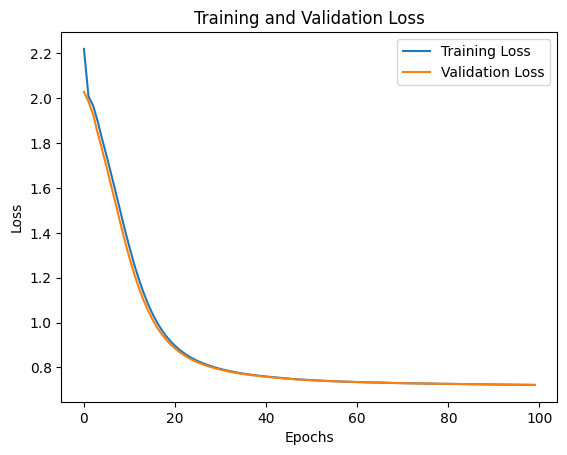

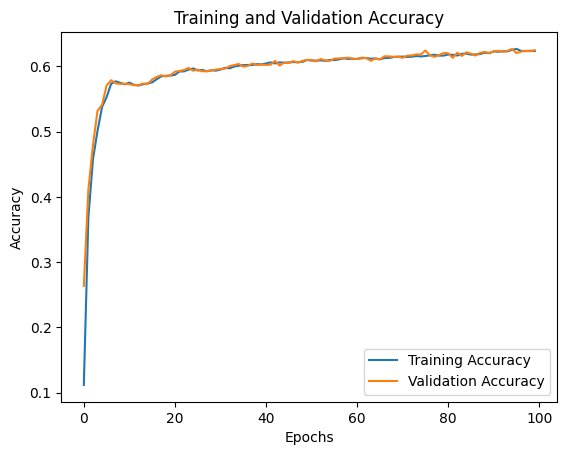

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model.save('model2')

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets
